# Visualizing my job search process in 2023
1. Sankey flow of job applications to results
2. Tracking flow of applications, informational chats, and formal interviews

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 1. Job application results

In [2]:
df = pd.read_csv('data/job_apps_2023.txt',sep='\t')
df

,id,company,title,app_response,interview,offer,personal_contact
0,1,X,PhD Residency,Lost to the Abyss,NaN,No,Yes
1,2,Adaptive,Computational Biologist II,Automated Reject,NaN,No,Yes
2,3,MSR AI4Science,Intern,Lost to the Abyss,NaN,No,Yes
3,4,Google Research,Data Science Intern,Lost to the Abyss,NaN,No,Yes
4,5,X,PhD Residency - Planetary Health,Lost to the Abyss,NaN,No,Yes
...,...,...,...,...,...,...,...
75,76,Ginkgo,ML/AI Engineer - RNA/DNA Design,Interview Request,Job Talk,Yes,Yes
76,77,Amazon,Research Scientist - Sustainability,Lost to the Abyss,NaN,No,No
77,78,Funga,Bioinformatician,Interview Request,Terminated,Unknown,Yes
78,79,Allonnia,Data Scientist,Interview Request,NaN,Unknown,No


In [15]:
# Counts on application paths
counts = {}

In [16]:
# Job App with Personal Contact counts
pc = df[df['personal_contact']=='Yes']
counts[("Job Applications","Personal Contact")] = pc.shape[0]

# Job App with Cold Applied counts
cold = df[df['personal_contact']!='Yes']
counts[("Job Applications","Cold Applied")] = cold.shape[0]

counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38}

In [17]:
# Personal contact value counts
pc_vc = pc['app_response'].value_counts()
# Cold applied value counts
cold_vc = cold['app_response'].value_counts()

# response counts for personal contact
for key in pc_vc.keys():
    counts[("Personal Contact",key)] = pc_vc[key]

# response counts for cold applies
for key in cold_vc.keys():
    counts[("Cold Applied",key)] = cold_vc[key]
    
counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4}

In [18]:
# interview request counts
int_vc = df['interview'].value_counts()

# define the flow of which interview types fed into counts of the others
# aka Job Talks were always preceeded by an initial screen and meeting more team members
int_flow = {
    'Initial Screen':['Initial Screen','Meet Team','Job Talk','Terminated'],
    'Meet Team':['Meet Team','Job Talk'],
    'Job Talk':['Job Talk'],
    'Terminated':['Terminated']
}

# sum the counts of interview types that are subsets of others
int_counts = {}
for y in int_flow:
    int_counts[y] = sum([int_vc[x] for x in int_flow[y]])

int_counts

{'Initial Screen': 12, 'Meet Team': 6, 'Job Talk': 3, 'Terminated': 1}

In [19]:
# group by application reponse and final offer result 
dfg = df.groupby(["app_response","offer"])

# group interview types by final offer result
intg = df.fillna('')[df['app_response']=='Interview Request'].groupby(['interview',"offer"])

# Count number of rejections to final offer results
for response, result in dfg.groups:
    if response != "Interview Request":
        c = dfg.get_group((response,result)).shape[0]
        counts[(response,result)] = c
        print(response, result, c)

# Count number of interview types to final offer results
for interview,result in intg.groups:
    c = intg.get_group((interview,result)).shape[0]
    #print("INT RES", interview, result)
    if interview == '':
        print("INT NO SCREEN")
        counts[("Interview Request",result)] = c
    else:
        counts[(interview,result)] = c
    print(interview, result,c)

counts

Automated Reject No 21
Human Reject No 3
Lost to the Abyss No 41
INT NO SCREEN
 Unknown 3
Initial Screen No 5
Job Talk No 1
Job Talk Yes 2
Meet Team No 3
Terminated Unknown 1


{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4,
 ('Automated Reject', 'No'): 21,
 ('Human Reject', 'No'): 3,
 ('Lost to the Abyss', 'No'): 41,
 ('Interview Request', 'Unknown'): 3,
 ('Initial Screen', 'No'): 5,
 ('Job Talk', 'No'): 1,
 ('Job Talk', 'Yes'): 2,
 ('Meet Team', 'No'): 3,
 ('Terminated', 'Unknown'): 1}

In [20]:
# manually set these counts based on the tree structure I have in my head
counts[("Interview Request","Initial Screen")] = int_counts['Initial Screen']
counts[("Initial Screen","Meet Team")] = int_counts['Meet Team']
counts[("Meet Team","Job Talk")] = int_counts['Job Talk']
counts[("Initial Screen","Terminated")] = int_counts['Terminated']
counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4,
 ('Automated Reject', 'No'): 21,
 ('Human Reject', 'No'): 3,
 ('Lost to the Abyss', 'No'): 41,
 ('Interview Request', 'Unknown'): 3,
 ('Initial Screen', 'No'): 5,
 ('Job Talk', 'No'): 1,
 ('Job Talk', 'Yes'): 2,
 ('Meet Team', 'No'): 3,
 ('Terminated', 'Unknown'): 1,
 ('Interview Request', 'Initial Screen'): 12,
 ('Initial Screen', 'Meet Team'): 6,
 ('Meet Team', 'Job Talk'): 3,
 ('Initial Screen', 'Terminated'): 1}

In [21]:
# convert to pandas dataframe
sank_data2 = []
for (s,t) in counts:
    sank_data2.append([s,t,counts[(s,t)]])
    
node_sort = ['Job Applications','Personal Contact','Cold Applied',
             'Lost to the Abyss','Automated Reject','Human Reject','Interview Request',
             'Initial Screen','Meet Team','Job Talk','Terminated',
             'No','Yes','Unknown']

sdf = pd.DataFrame(sank_data2,columns = ['source','target','count'])
sdf['node_sort1'] = pd.Categorical(sdf['source'], node_sort,ordered=True)
sdf['node_sort2'] = pd.Categorical(sdf['target'], node_sort)
sdf.sort_values(['node_sort1','node_sort2'],inplace=True)
sdf

,source,target,count,node_sort1,node_sort2
0,Job Applications,Personal Contact,42,Job Applications,Personal Contact
1,Job Applications,Cold Applied,38,Job Applications,Cold Applied
2,Personal Contact,Lost to the Abyss,22,Personal Contact,Lost to the Abyss
4,Personal Contact,Automated Reject,6,Personal Contact,Automated Reject
5,Personal Contact,Human Reject,3,Personal Contact,Human Reject
3,Personal Contact,Interview Request,11,Personal Contact,Interview Request
6,Cold Applied,Lost to the Abyss,19,Cold Applied,Lost to the Abyss
7,Cold Applied,Automated Reject,15,Cold Applied,Automated Reject
8,Cold Applied,Interview Request,4,Cold Applied,Interview Request
11,Lost to the Abyss,No,41,Lost to the Abyss,No


In [22]:
sdf[['source','target','count']].to_csv('data/sankey_data.csv')

## Create Sankey viz in Plotly

In [23]:
# plotly version
import plotly.graph_objects as go


In [24]:
# test plot
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": ["A", "B", "C", "D", "E", "F"],
        "x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        "y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        'pad':10},  # 10 Pixels
    link = {
        "source": [0, 0, 1, 2, 5, 4, 3, 5],
        "target": [5, 3, 4, 3, 0, 2, 2, 3],
        "value": [1, 2, 1, 1, 1, 1, 1, 2]}))

fig.show()

In [25]:
# create mapping of node to index
node_idx = enumerate(node_sort)
node_map = dict([(y,x) for (x,y) in node_idx])
node_map

{'Job Applications': 0,
 'Personal Contact': 1,
 'Cold Applied': 2,
 'Lost to the Abyss': 3,
 'Automated Reject': 4,
 'Human Reject': 5,
 'Interview Request': 6,
 'Initial Screen': 7,
 'Meet Team': 8,
 'Job Talk': 9,
 'Terminated': 10,
 'No': 11,
 'Yes': 12,
 'Unknown': 13}

In [26]:
# create index column
sdf['source_idx'] = sdf['source'].apply(lambda x: node_map[x])
sdf['target_idx'] = sdf['target'].apply(lambda x: node_map[x])
sdf

,source,target,count,node_sort1,node_sort2,source_idx,target_idx
0,Job Applications,Personal Contact,42,Job Applications,Personal Contact,0,1
1,Job Applications,Cold Applied,38,Job Applications,Cold Applied,0,2
2,Personal Contact,Lost to the Abyss,22,Personal Contact,Lost to the Abyss,1,3
4,Personal Contact,Automated Reject,6,Personal Contact,Automated Reject,1,4
5,Personal Contact,Human Reject,3,Personal Contact,Human Reject,1,5
3,Personal Contact,Interview Request,11,Personal Contact,Interview Request,1,6
6,Cold Applied,Lost to the Abyss,19,Cold Applied,Lost to the Abyss,2,3
7,Cold Applied,Automated Reject,15,Cold Applied,Automated Reject,2,4
8,Cold Applied,Interview Request,4,Cold Applied,Interview Request,2,6
11,Lost to the Abyss,No,41,Lost to the Abyss,No,3,11


In [27]:
# calculate total counts at each node
node_count_dict = dict(sdf.groupby('source').sum('count').reset_index()[['source','count']].values)
# final results that were never source nodes
finals = ['Yes','No','Unknown']
temp = sdf.groupby('target').sum('count').reset_index()[['target','count']]
temp = dict(temp[temp['target'].isin(finals)].values)
node_count_dict = node_count_dict | temp
node_count_dict

{'Automated Reject': 21,
 'Cold Applied': 38,
 'Human Reject': 3,
 'Initial Screen': 12,
 'Interview Request': 15,
 'Job Applications': 80,
 'Job Talk': 3,
 'Lost to the Abyss': 41,
 'Meet Team': 6,
 'Personal Contact': 42,
 'Terminated': 1,
 'No': 74,
 'Unknown': 4,
 'Yes': 2}

In [28]:
# create two text lines for small nodes
small_boxes = ["Human Reject", "Job Talk"]
node_labels = ['<br>'.join(x.split()) if x in small_boxes else x for x in node_sort ]

# add node count tag to the end
node_tags = [node_count_dict[x] for x in node_sort]
node_labels = [node_labels[i] + f' <b>{node_tags[i]}</b>' for i in range(len(node_labels))]

node_labels

['Job Applications <b>80</b>',
 'Personal Contact <b>42</b>',
 'Cold Applied <b>38</b>',
 'Lost to the Abyss <b>41</b>',
 'Automated Reject <b>21</b>',
 'Human<br>Reject <b>3</b>',
 'Interview Request <b>15</b>',
 'Initial Screen <b>12</b>',
 'Meet Team <b>6</b>',
 'Job<br>Talk <b>3</b>',
 'Terminated <b>1</b>',
 'No <b>74</b>',
 'Yes <b>2</b>',
 'Unknown <b>4</b>']

In [29]:
# assign my own node colors
# weird note: colors that start with #FF make the links full red... not sure why.
# switching them to #FE fixed this... *shrug*
node_color = dict(enumerate([
    '#fed67a',# 0 'Job Applications',
    '#858dfb',# 1 'Personal Contact',
    '#bc85fb',# 2 'Cold Applied',
    '#FEB57E',#'#058b05',#'#ffb57e',# 3 'Lost to the Abyss',
    '#fe87a9',# 4 'Automated Reject',
    '#feadfe',# 5 'Human Reject',
    '#51AFF5',# 6 'Interview Request',
    '#50dcf6',# 7 'Initial Screen',
    '#3ad7ac',# 8 'Meet Team',
    '#34B83D',# 9 'Job Talk',
    '#BDBBBD',# 10 'Terminated',
    '#f27a67',# 11 'No',
    '#8FD63A',# 12 'Yes',
    '#adadad',# 13 'Unknown',
]))

from matplotlib.colors import to_rgba

# needed to switch these to rgba because plotly wouldn't accept HEX with transparency?
link_color = [to_rgba(node_color[x]) for x in node_color]
link_color = dict(enumerate([f'rgba({r:.3f},{g:.3f},{b:.3f},0.5)'for r,g,b,a in link_color]))

link_color

{0: 'rgba(0.996,0.839,0.478,0.5)',
 1: 'rgba(0.522,0.553,0.984,0.5)',
 2: 'rgba(0.737,0.522,0.984,0.5)',
 3: 'rgba(0.996,0.710,0.494,0.5)',
 4: 'rgba(0.996,0.529,0.663,0.5)',
 5: 'rgba(0.996,0.678,0.996,0.5)',
 6: 'rgba(0.318,0.686,0.961,0.5)',
 7: 'rgba(0.314,0.863,0.965,0.5)',
 8: 'rgba(0.227,0.843,0.675,0.5)',
 9: 'rgba(0.204,0.722,0.239,0.5)',
 10: 'rgba(0.741,0.733,0.741,0.5)',
 11: 'rgba(0.949,0.478,0.404,0.5)',
 12: 'rgba(0.561,0.839,0.227,0.5)',
 13: 'rgba(0.678,0.678,0.678,0.5)'}

In [30]:
sdf['source_color'] = sdf['source_idx'].apply(lambda x: link_color[x])
sdf['target_color'] = sdf['target_idx'].apply(lambda x: link_color[x])
sdf

,source,target,count,node_sort1,node_sort2,source_idx,target_idx,source_color,target_color
0,Job Applications,Personal Contact,42,Job Applications,Personal Contact,0,1,"rgba(0.996,0.839,0.478,0.5)","rgba(0.522,0.553,0.984,0.5)"
1,Job Applications,Cold Applied,38,Job Applications,Cold Applied,0,2,"rgba(0.996,0.839,0.478,0.5)","rgba(0.737,0.522,0.984,0.5)"
2,Personal Contact,Lost to the Abyss,22,Personal Contact,Lost to the Abyss,1,3,"rgba(0.522,0.553,0.984,0.5)","rgba(0.996,0.710,0.494,0.5)"
4,Personal Contact,Automated Reject,6,Personal Contact,Automated Reject,1,4,"rgba(0.522,0.553,0.984,0.5)","rgba(0.996,0.529,0.663,0.5)"
5,Personal Contact,Human Reject,3,Personal Contact,Human Reject,1,5,"rgba(0.522,0.553,0.984,0.5)","rgba(0.996,0.678,0.996,0.5)"
3,Personal Contact,Interview Request,11,Personal Contact,Interview Request,1,6,"rgba(0.522,0.553,0.984,0.5)","rgba(0.318,0.686,0.961,0.5)"
6,Cold Applied,Lost to the Abyss,19,Cold Applied,Lost to the Abyss,2,3,"rgba(0.737,0.522,0.984,0.5)","rgba(0.996,0.710,0.494,0.5)"
7,Cold Applied,Automated Reject,15,Cold Applied,Automated Reject,2,4,"rgba(0.737,0.522,0.984,0.5)","rgba(0.996,0.529,0.663,0.5)"
8,Cold Applied,Interview Request,4,Cold Applied,Interview Request,2,6,"rgba(0.737,0.522,0.984,0.5)","rgba(0.318,0.686,0.961,0.5)"
11,Lost to the Abyss,No,41,Lost to the Abyss,No,3,11,"rgba(0.996,0.710,0.494,0.5)","rgba(0.949,0.478,0.404,0.5)"


In [49]:
fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

# I didn't like the auto layout view, so I moved them precisely where I liked them, 
        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.34, 0.43, 0.38,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.35, 1.2, 
              1.25, 0.65, 0.35, 0.1,
              0.15, 
              0.11, 0.14, -0.01,
              0.95, 0.17, 0.001,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        #'hovertemplate':'%{source.label} --> %{target.label}: <extra>%{value:1f}</extra>',
        'hovertemplate':'%{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    )
)

fig.show()

In [78]:
fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

# I didn't like the auto layout view, so I moved them precisely where I liked them, 
        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.34, 0.43, 0.34,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.35, 1.2, 
              1.25, 0.65, 0.35, 0.1,
              0.05, 
              0.001, 0.002, 0.23,
              0.95, 0.001, 0.13,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        #'hovertemplate':'%{source.label} --> %{target.label}: <extra>%{value:1f}</extra>',
        'hovertemplate':'%{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    )
)

fig.show()

In [79]:
fig.write_html('sankey_plot.html')
#fig.write_json('sankey_plot.json')

## Tracking applications and career conversations over time

In [99]:
cdf = pd.read_csv('data/convos_2023.txt',sep='\t')
cdf['Date'] = pd.to_datetime(cdf['Date'])
#cdf['Type'] = cdf['Type'].astype(str)

cdf

,Type,Company,Person,Date,Sector,Location
0,0,Ginkgo,Jason Stevens,2022-09-15,BCD,E
1,0,ISB,Nitin Baliga,2022-09-20,BD,M
2,0,ISB,Jake Valenzuela,2022-09-26,BD,M
3,0,Novo Nordisk,Melih Yilmaz,2022-10-07,BD,M
4,0,ISB,Eliza Peterson,2022-10-12,BD,Z
...,...,...,...,...,...,...
98,2,Form Bio,Christina Capehart,2023-10-06,BD,Z
99,1,Carbon Drop,Spencer Mains,2023-10-05,BCD,Z
100,4,LanzaTech,LanzaTech Team (+job talk),2023-10-11,BCD,Z
101,0,Spark Climate,Laura Adams,2023-09-26,C,E


In [112]:
casual_df = cdf[cdf['Type']==0]
interview_df = cdf[cdf['Type']>0]
interview_df['Type'] = interview_df['Type'].astype(str)

interview_df

/var/folders/z0/53b9pdsx1hg30nbh705jh_ym0000gn/T/ipykernel_99645/4200871155.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Type,Company,Person,Date,Sector,Location
31,1,Invert Bio,Martin Permin,2023-01-18,BD,Z
34,2,Invert Bio,Andy Elmsley,2023-01-31,BD,Z
36,3,Invert Bio,Holger Thorup,2023-02-07,BD,Z
54,1,IUNU,Sydney/Quincy/Rohini,2023-04-04,CD,Z
64,1,Homeworld Collective,Paul Reginato,2023-06-19,BC,Z
73,1,Nori,Radhika Moolgavkar,2023-07-17,CD,Z
75,2,Nori,Nori Team,2023-07-27,CD,Z
76,3,Nori,Nori Team,2023-08-04,CD,M
78,1,AI2,Liza Ray,2023-08-15,BD,Z
83,1,Think Bioscience,Jill Kohla,2023-08-25,BD,Z


In [113]:
adf = pd.read_csv('data/job_apps_2023_timeline.txt',sep='\t')
adf['Date'] = pd.to_datetime(adf['Date'])
adf

,Type,Company,Title,Date,Sector,Seattle?,Human contact,Interview stage,Offer?
0,-1,X,PhD Residency,2023-01-16,BD,0,No,0,No
1,-1,Adaptive,Computational Biologist II,2023-01-18,BD,1,No,0,No
2,-1,MSR AI4Science,Intern,2023-01-20,BD,0,No,0,No
3,-1,Google Research,Data Science Intern,2023-01-26,D,1,No,0,No
4,-1,X,PhD Residency - Planetary Health,2023-01-31,CD,0,No,0,No
...,...,...,...,...,...,...,...,...,...
76,-1,Ginkgo,ML/AI Engineer - RNA/DNA Design,2023-10-05,BCD,0,Yes,2,Yes
77,-1,Amazon,Research Scientist - Sustainability,2023-10-23,CD,1,No,0,No
78,-1,Funga,Bioinformatician,2023-10-31,BCD,0,Yes,1,Unknown
79,-1,Allonnia,Data Scientist,2023-10-31,BCD,0,Yes,1,Unknown


In [114]:
apps = alt.Chart(adf).mark_point().encode(
    x='Date',
)

convos = alt.Chart(cdf).mark_point().encode(
    x=alt.X('Date', axis=alt.Axis(tickMinStep=2,format='%b, %Y')),#scale = alt.Scale(nice={'interval':'month','step':30})),
    y=alt.Y('Type:O',sort='descending')
)

convos.properties(
    width=500,
    height=100
)

alt.Chart(...)

In [148]:
odf = pd.DataFrame(
    data=[['Ginkgo','2023-11-09'],
          ['LanzaTech','2023-11-10']],
    columns=['Company','Date']
)
odf['Date'] = pd.to_datetime(odf['Date'])
odf

,Company,Date
0,Ginkgo,2023-11-09
1,LanzaTech,2023-11-10


In [115]:
import matplotlib.dates as mdates

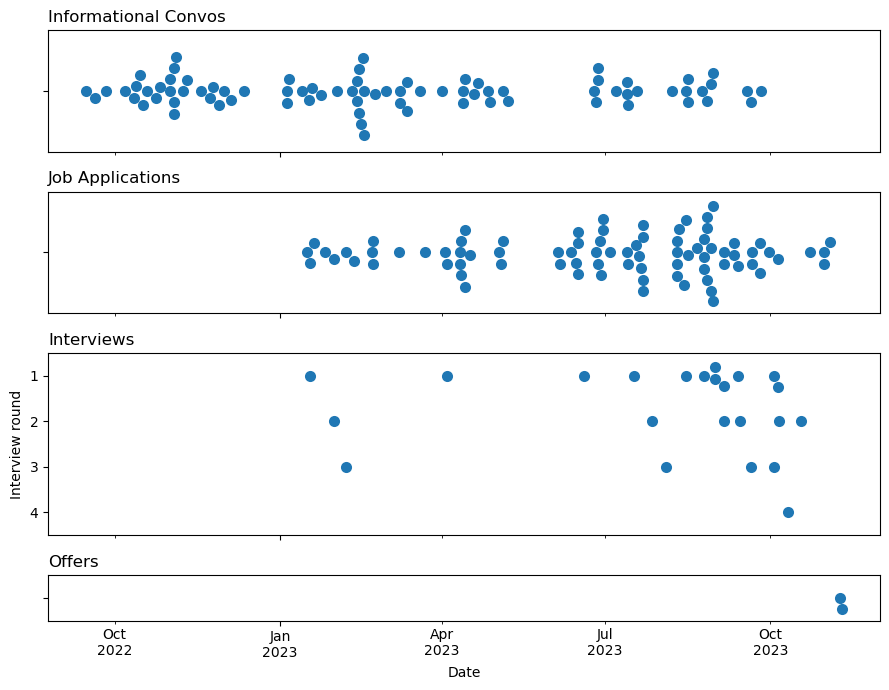

In [157]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(
    4,1,
    sharex=True,
    figsize=(9,7),
    gridspec_kw={'height_ratios': [2,2,3,0.75]}
)
sns.swarmplot(data=casual_df,x='Date',ax=ax1,size=8,)
sns.swarmplot(data=adf,x='Date',ax=ax2,size=8,)
sns.swarmplot(data=interview_df,x='Date',y="Type",ax=ax3,size=8,)
sns.swarmplot(data=odf,x='Date',ax=ax4,size=8,)


locator = mdates.MonthLocator(bymonth=[4,7,10])
ax4.xaxis.set_minor_locator(locator)
#ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
ax4.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_title("Informational Convos",loc='left')
ax2.set_title("Job Applications",loc='left')
ax3.set_title("Interviews",loc='left')
ax3.set_ylabel("Interview round")

ax4.set_title("Offers",loc='left')

plt.tight_layout()

In [ ]:
# add offer dates nov 9 and 10?

# Scratch

In [25]:
# attempt export to chart studio for easy sharing online?
import chart_studio
import chart_studio.plotly as py

username='erinhwilson'
api_key='' # paste
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [108]:
# exporting to chart studio does not preserve the style/alignment in the fig... >.< 
py.plot(fig, filename="sankey_job", auto_open = True)


'https://plotly.com/~erinhwilson/2/'

Trying to adjust the positions of nodes so it looks better in chart studio export (it's not exactly the same when exported), but it's not consistent and I gave up

In [107]:
fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_sort,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.34, 0.43, 0.38,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.36, 1.15, 
              1.15, 0.6, 0.3, 0.1,
              0.1, 
              0.125, 0.1, 0.01,
              0.87, 0.15, 0.01,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        'hovertemplate':'%{source.label} --> %{target.label}: %{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    ))
fig.show()

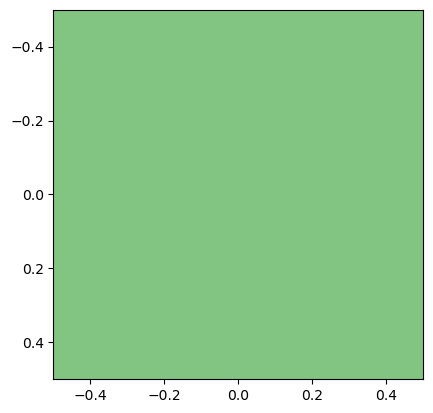

In [127]:
# check rgba value
val = [0.020,0.545,0.020,0.5]
plt.imshow([[val]])

In [156]:
sdf[sdf['source']=="Cold Applied"][['source','target','target_color']].values

array([['Cold Applied', 'Lost to the Abyss',
        'rgba(1.000,0.835,0.553,0.5)'],
       ['Cold Applied', 'Automated Reject',
        'rgba(1.000,0.529,0.663,0.5)'],
       ['Cold Applied', 'Interview Request',
        'rgba(0.318,0.686,0.961,0.5)']], dtype=object)

In [182]:
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

#         "x": [0.0, 
#               0.1, 0.1, 
#               0.2, 0.2, 0.2, 0.2,
#               0.25, 
#               0.3, 0.4, 0.35,
#               0.5, 0.5, 0.5,],
#         "y": [0, 
#               0.55, 1.85, 
#               1.9, 1.0, 0.55, 0.2,
#               0.2, 0.2, 0.2, -0.01,
#               1.4, 0.2, -0.01,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values
    },
    orientation = 'v',
),
)

fig.show()

In [10]:
# import holoviews as hv
# from holoviews import opts, dim
# hv.extension('bokeh')

# sankey = hv.Sankey(sdf)
# sankey.opts(width=600, height=400,node_sort=False,edge_color='target',)

In [174]:
sankey = hv.Sankey([
    ['A', 'X', 5],
    ['A', 'Y', 7],
    ['A', 'Z', 6],
    ['B', 'X', 2],
    ['B', 'Y', 9],
    ['B', 'Z', 4],
    ['Z', 'J', 3],
]
)
sankey.opts(width=600, height=400)

:Sankey   [start,end]   (Value)